# SSTT - Contaminación


## Antecedentes

Este cuaderno es una prueba de concepto de ajuste de un modelo con las siguientes restricciones:

1. El conjunto de datos es **multivariante**
2. La variable dependiente **no tiene estacionalidad**, pero los regresores sí.
3. La predicción se realizará **sin proporcionar regresores exógenos** en ningún punto del "futuro"
4. Se predecirán 100 instantes de tiempo futuro.


Este Notebook utiliza **MLP** (Multi-Layer Perception) multivariado para un conjunto de valores obtenidos de un dataset de contaminación del aire. 

Puesto que la predicción debe hacerse sin proporcionar variables regresoras, se han descartado los modelos basados en ARIMA como **SARIMAX** o **PROPHET**, puesto que, aunque se puede entrenar con estas variables exógenas, necesitas incluir las variables exógenas futuras para la predicción posterior. 

## 1 - Importacion de librerías

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

## 2 - Carga de datos

In [226]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
dataset = pd.read_csv('pollution.csv', parse_dates=['date'], date_parser=dateparse)

C:\Users\Fabian\AppData\Local\Temp\ipykernel_17924\803121332.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = pd.read_csv('pollution.csv', parse_dates=['date'], date_parser=dateparse)


`wnd_dir` no será necesaria para el modelo

In [227]:
dataset = dataset.drop(["wnd_dir"], axis = 1)

In [228]:
dataset.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0


## 3 - Visualización

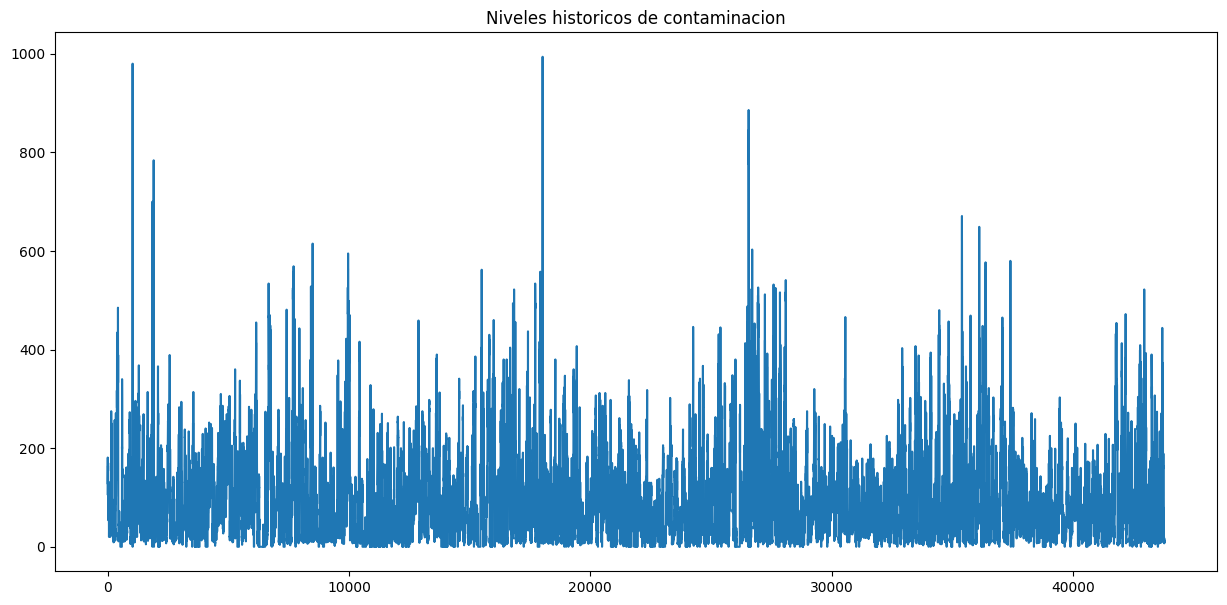

In [229]:
fig, ax = plt.subplots(figsize = (15,7))
plt.plot(dataset['pollution'])
plt.title('Niveles historicos de contaminacion')
plt.show()

In [230]:
dataset.shape

(43800, 8)

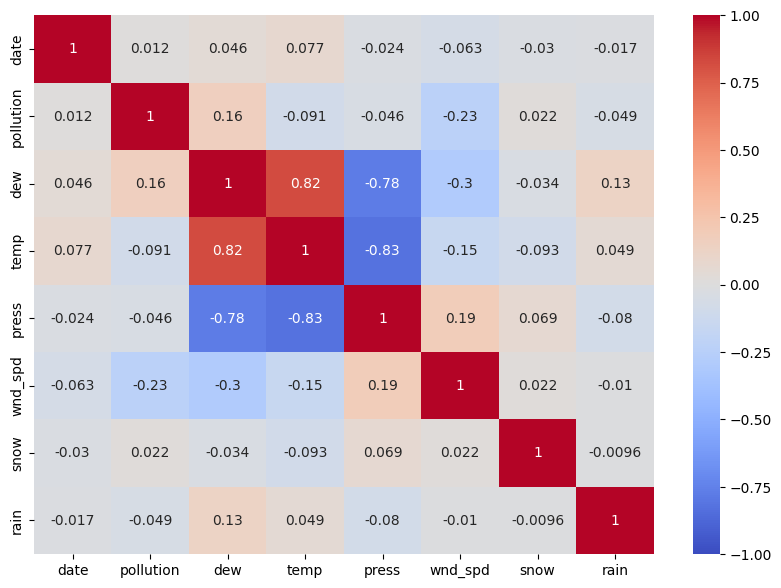

In [231]:
cor = dataset.corr()

fig, ax = plt.subplots(figsize = (10,7))
sns.heatmap(cor, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.show()

Pollutions tiene correlación con :
- `wind_spd`
- `dew`

De hecho, la correlación negativa más alta es con la velocidad del viento, lo cual tiene sentido ya que podemos pensar que la contaminación es mayor cuando no sopla viento para limpiar la atmósfera.

Acontunuación se mostrarán las graficas de **aurocorrelación.** Como tenemos datos por cada hora, para representar la correlacion de rezagos semanales se impondrán 'lags' = 24*7 (número de horas por semana)  

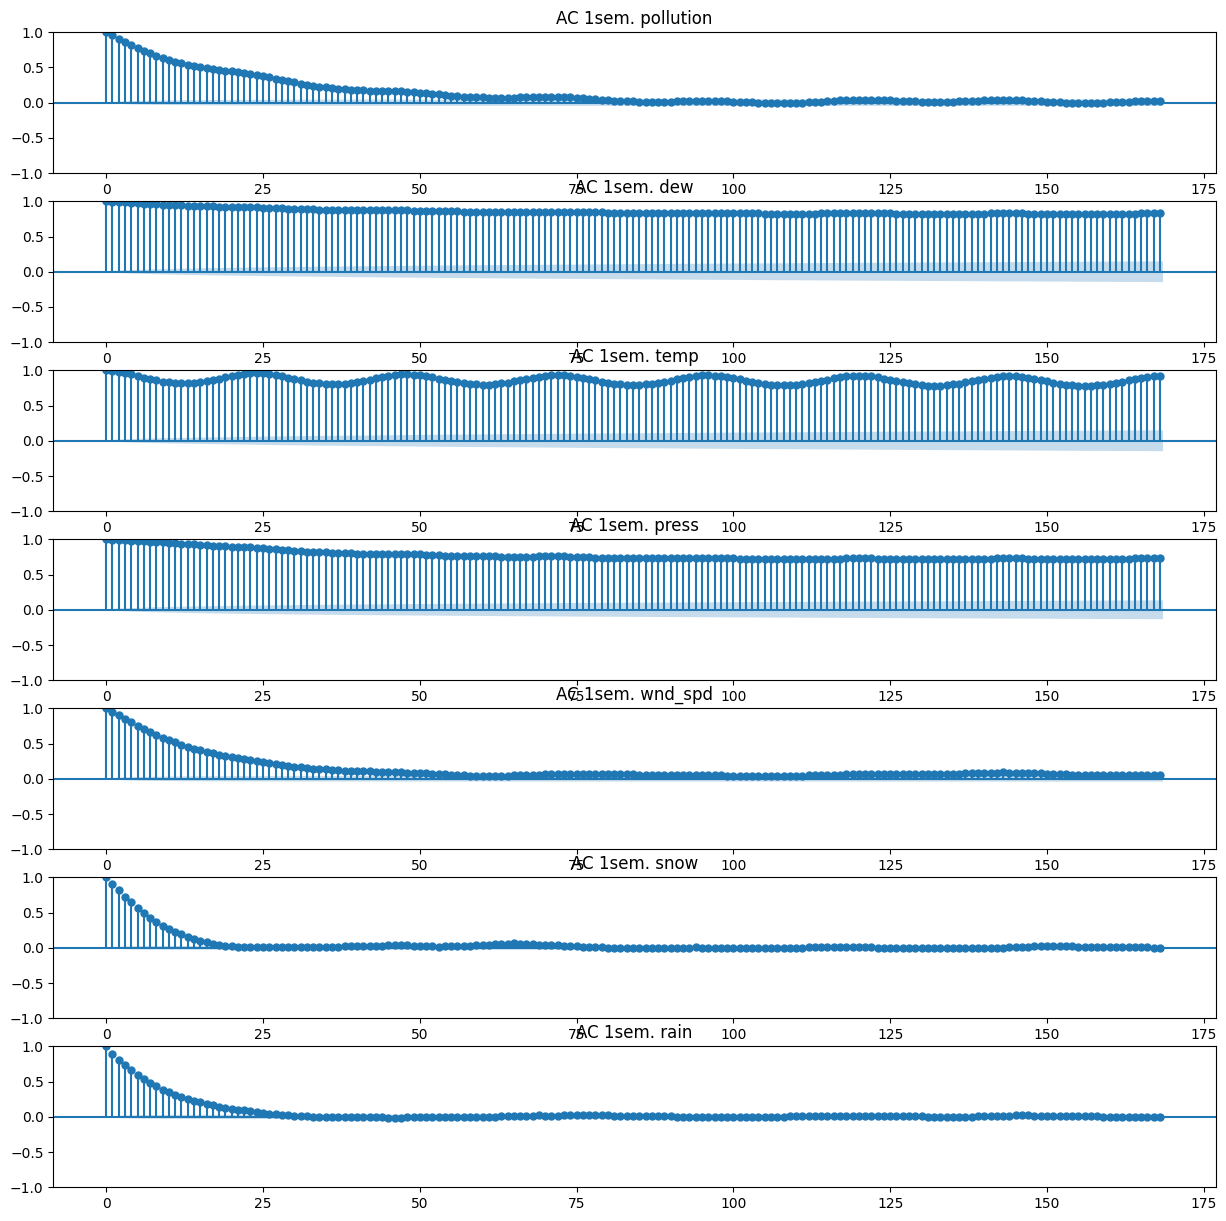

In [232]:

numeric_vars = ['dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
fig, axs = plt.subplots(len(numeric_vars)+1, 1, figsize = (15, 15))

# Gráfico de autocorrelación para la variable "pollution"
plot_acf(dataset["pollution"], title="AC 1sem. pollution", lags=24*7, ax=axs[0])

# Gráficos de autocorrelación para las variables numéricas
for i, colname in enumerate(numeric_vars, 1):
    plot_acf(dataset[colname], title="AC 1sem. " + colname, lags=24*7, ax=axs[i])

Comprobamos que la temperatura tiene ciclos de autocorrelación estacionales **diarios**, pero si probamos `lag=24*365` comprobamos que tanto la temperatura, como presión y rocío tienen ciclos autocorrelativos estacoinales **anuales**.

Las demás columnas numéricas tienen valores autoccorelativos **aleatorios**

## 4 - Ajuste de características

La columna `date` no es útil en segundos, por lo que vamos a cambiar la perioricidad a días y la vamos a "codificar" mediante señales sinusoidales

La conversión de fechas a componentes sinusoidales es útil en el análisis de series de tiempo para permitir que los modelos capturen mejor patrones cíclicos como los cambios diarios

In [233]:
day = 24*60*60  
dataset['date'] = dataset['date'].map(pd.Timestamp.timestamp)

In [234]:
dataset['day_sin'] = np.sin(dataset['date'] * (2 * np.pi / day))
dataset['day_cos'] = np.cos(dataset['date'] * (2 * np.pi / day))

dataset = dataset.drop("date", axis = 1)    # Eliminacion de la columna fechas, representada por las nuevas columnas 'day_sin' y 'day_cos'
dataset

,pollution,dew,temp,press,wnd_spd,snow,rain,day_sin,day_cos
0,129.0,-16,-4.0,1020.0,1.79,0,0,-1.183198e-13,1.000000
1,148.0,-15,-4.0,1020.0,2.68,0,0,2.588190e-01,0.965926
2,159.0,-11,-5.0,1021.0,3.57,0,0,5.000000e-01,0.866025
3,181.0,-7,-5.0,1022.0,5.36,1,0,7.071068e-01,0.707107
4,138.0,-7,-5.0,1022.0,6.25,2,0,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...
43795,8.0,-23,-2.0,1034.0,231.97,0,0,-9.659258e-01,0.258819
43796,10.0,-22,-3.0,1034.0,237.78,0,0,-8.660254e-01,0.500000
43797,10.0,-22,-3.0,1034.0,242.70,0,0,-7.071068e-01,0.707107
43798,8.0,-22,-4.0,1034.0,246.72,0,0,-5.000000e-01,0.866025


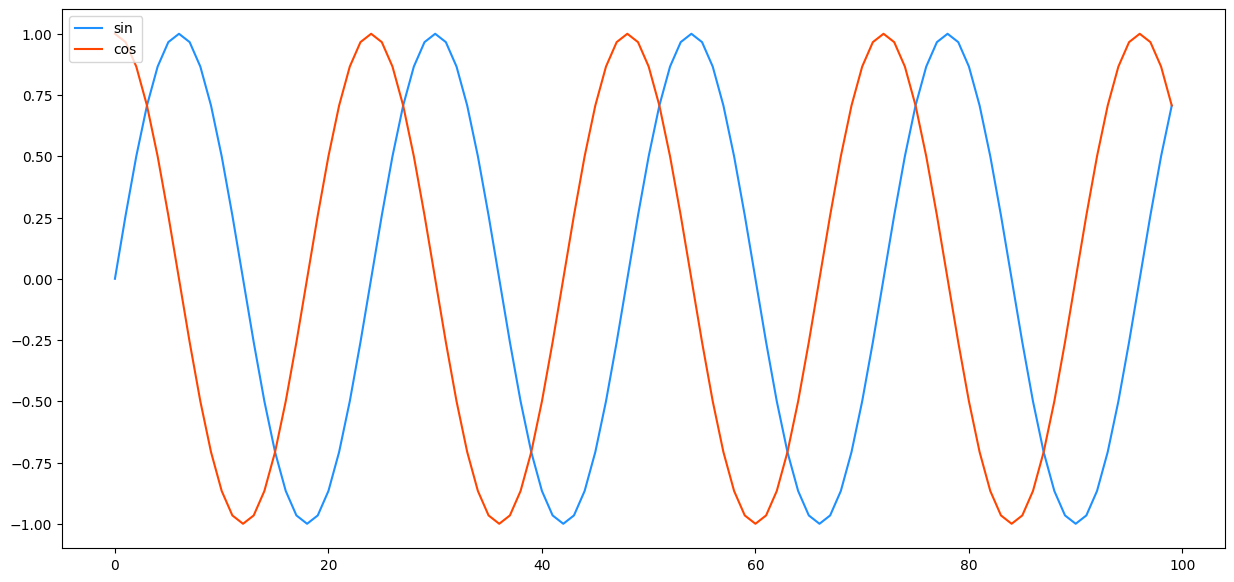

In [235]:
fig, axs = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
plt.plot(dataset['day_sin'].iloc[0:100], label = 'sin', color='dodgerblue')
plt.plot(dataset['day_cos'].iloc[0:100], label = 'cos', color='orangered')
plt.legend(loc = "upper left")
plt.show()

Normalizamos los datos (estandarización del tipo Z-score).

In [236]:
dataset[numeric_vars] = (dataset[numeric_vars] - dataset[numeric_vars].mean())/dataset[numeric_vars].std()
dataset.reset_index(inplace=True)
dataset

,index,pollution,dew,temp,press,wnd_spd,snow,rain,day_sin,day_cos
0,0,129.0,-1.235575,-1.349834,0.345882,-0.441885,-0.069371,-0.137704,-1.183198e-13,1.000000
1,1,148.0,-1.166272,-1.349834,0.345882,-0.424093,-0.069371,-0.137704,2.588190e-01,0.965926
2,2,159.0,-0.889059,-1.431845,0.443239,-0.406301,-0.069371,-0.137704,5.000000e-01,0.866025
3,3,181.0,-0.611845,-1.431845,0.540597,-0.370518,1.245411,-0.137704,7.071068e-01,0.707107
4,4,138.0,-0.611845,-1.431845,0.540597,-0.352726,2.560194,-0.137704,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...
43795,43795,8.0,-1.720698,-1.185810,1.708888,4.159623,-0.069371,-0.137704,-9.659258e-01,0.258819
43796,43796,10.0,-1.651395,-1.267822,1.708888,4.275770,-0.069371,-0.137704,-8.660254e-01,0.500000
43797,43797,10.0,-1.651395,-1.267822,1.708888,4.374125,-0.069371,-0.137704,-7.071068e-01,0.707107
43798,43798,8.0,-1.651395,-1.349834,1.708888,4.454489,-0.069371,-0.137704,-5.000000e-01,0.866025


Este tipo de estandarización difiere del escalamiento Robusto o del Min-Max en que su rango está entre [-3, 3] en la mayor parte de casos y mantiene la distribucion original. La diferencia con los anteriores es que es sensible a valores atipicos

# 5 - Forward validation

Se establecen los "Golden standard" en series temporales. 

Entre los parámetros, necesitamos 100 unidades de tiempo de predicción (n_steps_out)

In [237]:
n_chunks = 6                        # tnúmero de validaciones o predicciones
n_steps_in, n_steps_out = 300, 100  # número de pasos de tiempo consecutivos de datos históricos que se utilizan como entrada y salida para el modelo 
                                    # (se utiliza la función split_sequences para transformar los datos en secuencias de entrada y salida en estos valores)
backcast_size = 500                 # tamaño de la ventana de datos históricos

### Visualizacion de datos de entrenaiento y prueba
A continuación se dividen los conjuntos de datos y se muestran el de entrenamiento y prueba de la variable 'Pollution' para cada uno de los *steps*

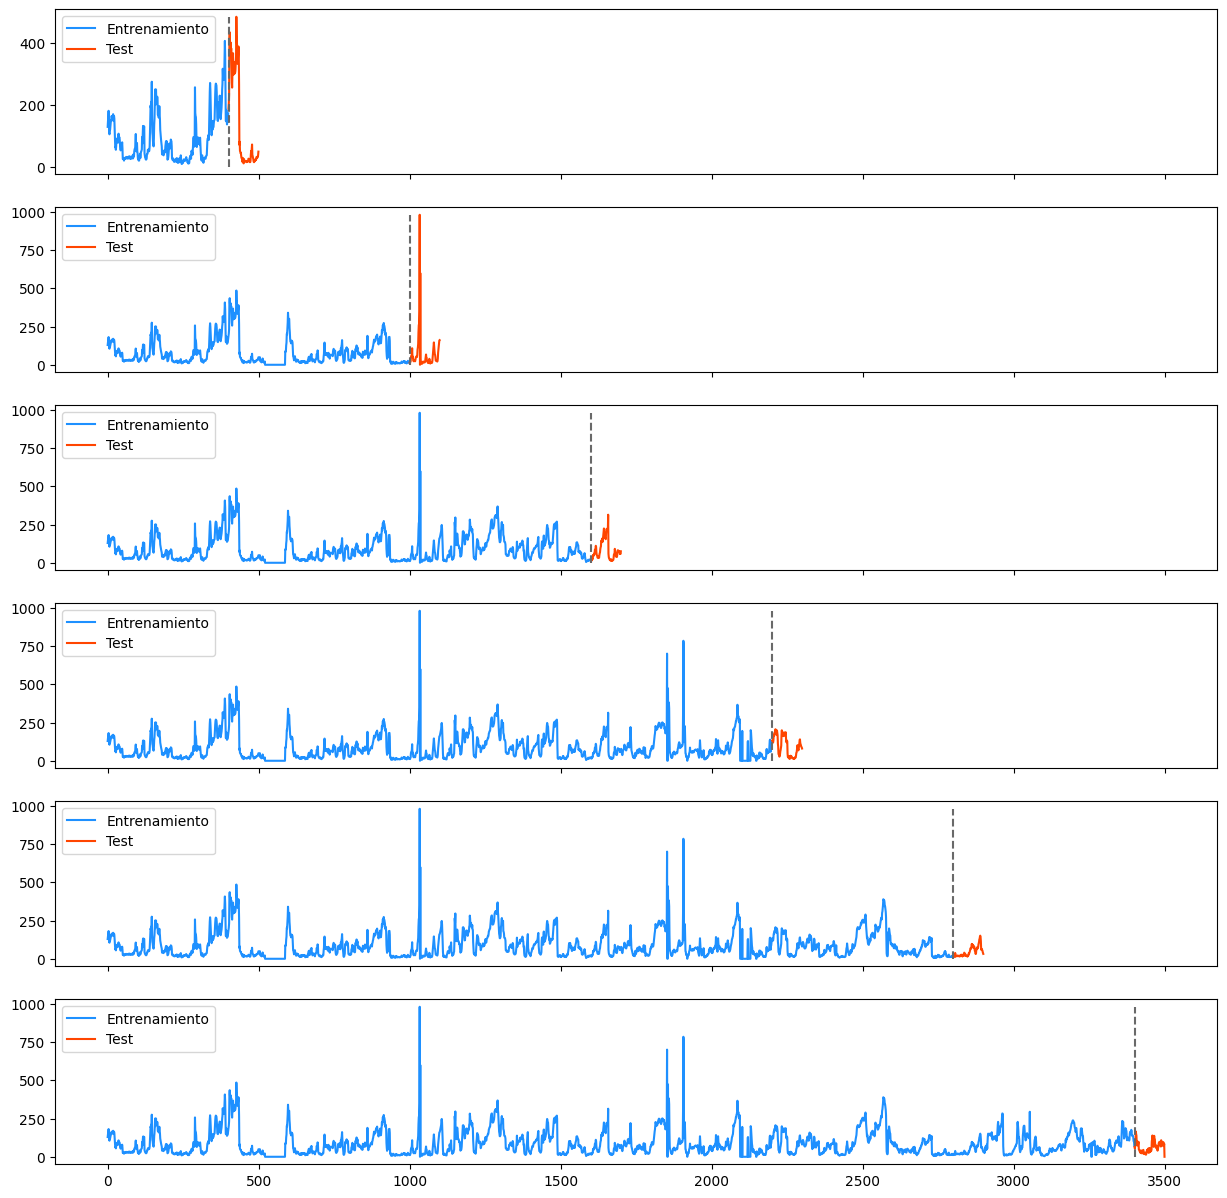

In [238]:
fig, axs = plt.subplots(n_chunks, 1, figsize = (15, 15), sharex = True)

for i, ax in zip(range(backcast_size, dataset.shape[0], backcast_size+n_steps_out), axs.ravel()):
    chunk_dataset = dataset.iloc[0:i]                               
    train = chunk_dataset['pollution'].iloc[0:i-n_steps_out]           
    test  = chunk_dataset['pollution'].iloc[i-n_steps_out:i]
    ax.plot(train, label = "Entrenamiento", color="dodgerblue")
    ax.plot([None for i in range(train.shape[0])] + [x for x in test], label = "Test", color="orangered")
    ax.vlines(x = i-n_steps_out, colors='dimgray', ymin = 0, ymax = max(train.max(), test.max()), linestyles='dashed')
    ax.legend(loc = "upper left")

La duración de la prueba es fija `n_steps_out = 100` , ya que solo cambian los conjuntos de entrenamiento.

In [239]:
dataset.shape

(43800, 10)

### Definicion de modelo y predicción

In [225]:
# Se define la funcion para la división de datos de entrenamiento
def split_sequences(sequences, target, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# divide cada secuencia en segmentos para entrada y salida
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# comprobación de que estamos fuera del rango de datos
		if out_end_ix > len(sequences):	
			# la longitud de sequences la rige la longitud de entrenamiento `train`			
			break
		# reunir los inputs y outputs
		seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences[target].iloc[end_ix-1:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [240]:
# se define el modelo de red neuronal fuera del bucle
def def_modelo(n_steps_out): 
    model = Sequential()
    model.add(Dense(512, activation='relu'))    # Agrega una capa densa con 512 neuronas y función de activación ReLU
    model.add(Dense(n_steps_out))               # Agrega una capa densa con n_steps_out neuronas (numero de pasos de salida ya mencionados)
    model.compile(optimizer='adam', loss='mse') # Se utiliza el optimizador Adam y la función de pérdida Mean Squared Error
    return(model)

In [241]:
mse_list, y_pred_list = [], []
n_step = 1
for i, ax in zip(range(backcast_size, dataset.shape[0], backcast_size+n_steps_out), axs.ravel()):
    print("---> Proceso de validación. Paso [%d/%d] "%(n_step,n_chunks))
    chunk_dataset = dataset.iloc[0:i]
    train = chunk_dataset.iloc[0:i-n_steps_out]
    test  = chunk_dataset.iloc[i-n_steps_out:i]

    # Entrenamiento:
    X_train, y_train = split_sequences(sequences = train, target = "pollution",
                                       n_steps_in = n_steps_in, n_steps_out = n_steps_out)
    
    print('DIMENSIÓN DATOS X ENTRENAMIENTO = (%d, %d)' % (X_train.shape[0], X_train.shape[1]))
    print('DIMENSIÓN DATOS Y ENTRENAMIENTO = (%d, %d)' % (y_train.shape[0], y_train.shape[1]))
    
    n_input = X_train.shape[1] * X_train.shape[2] 
    # n_imput --> Número de características de entrada para el modelo (num de pasos de tiempo * núm de características en cada paso)  
    X_train = X_train.reshape((X_train.shape[0], n_input))
    print("N_INPUT : %d" % n_input)
    
    # Prueba: (X_test es la ultima observación de X_train)
    X_test, y_test = X_train[-1].reshape(1,n_input), test['pollution']
    
    # Se define el modelo y se entrena con X_train, y_train
    model = def_modelo(n_steps_out)
    history = model.fit(X_train, y_train, epochs=1000, verbose=0)
    
    # Predicción
    y_pred = model.predict(X_train[-1].reshape(1,n_input), verbose=0)
    
    # Actualizar métricas y calculo de MSE
    y_pred_list.append(y_pred[0])
    mse_list.append(mean_squared_error(y_pred[0], y_test))
    n_step = n_step + 1

print("="*10,"PREDICCION FINALIZADA","="*10)

---> Proceso de validación. Paso [1/6] 
DIMENSIÓN DATOS X ENTRENAMIENTO = (2, 300)
DIMENSIÓN DATOS Y ENTRENAMIENTO = (2, 100)
N_INPUT : 2700
---> Proceso de validación. Paso [2/6] 
DIMENSIÓN DATOS X ENTRENAMIENTO = (602, 300)
DIMENSIÓN DATOS Y ENTRENAMIENTO = (602, 100)
N_INPUT : 2700
---> Proceso de validación. Paso [3/6] 
DIMENSIÓN DATOS X ENTRENAMIENTO = (1202, 300)
DIMENSIÓN DATOS Y ENTRENAMIENTO = (1202, 100)
N_INPUT : 2700
---> Proceso de validación. Paso [4/6] 
DIMENSIÓN DATOS X ENTRENAMIENTO = (1802, 300)
DIMENSIÓN DATOS Y ENTRENAMIENTO = (1802, 100)
N_INPUT : 2700
---> Proceso de validación. Paso [5/6] 
DIMENSIÓN DATOS X ENTRENAMIENTO = (2402, 300)
DIMENSIÓN DATOS Y ENTRENAMIENTO = (2402, 100)
N_INPUT : 2700
---> Proceso de validación. Paso [6/6] 
DIMENSIÓN DATOS X ENTRENAMIENTO = (3002, 300)
DIMENSIÓN DATOS Y ENTRENAMIENTO = (3002, 100)
N_INPUT : 2700
========== PREDICCION FINALIZADA ==========


### Visualización de predicciones
Una vez ajustado el modelo en todos los pasos, procedemos a ver las previsiones:

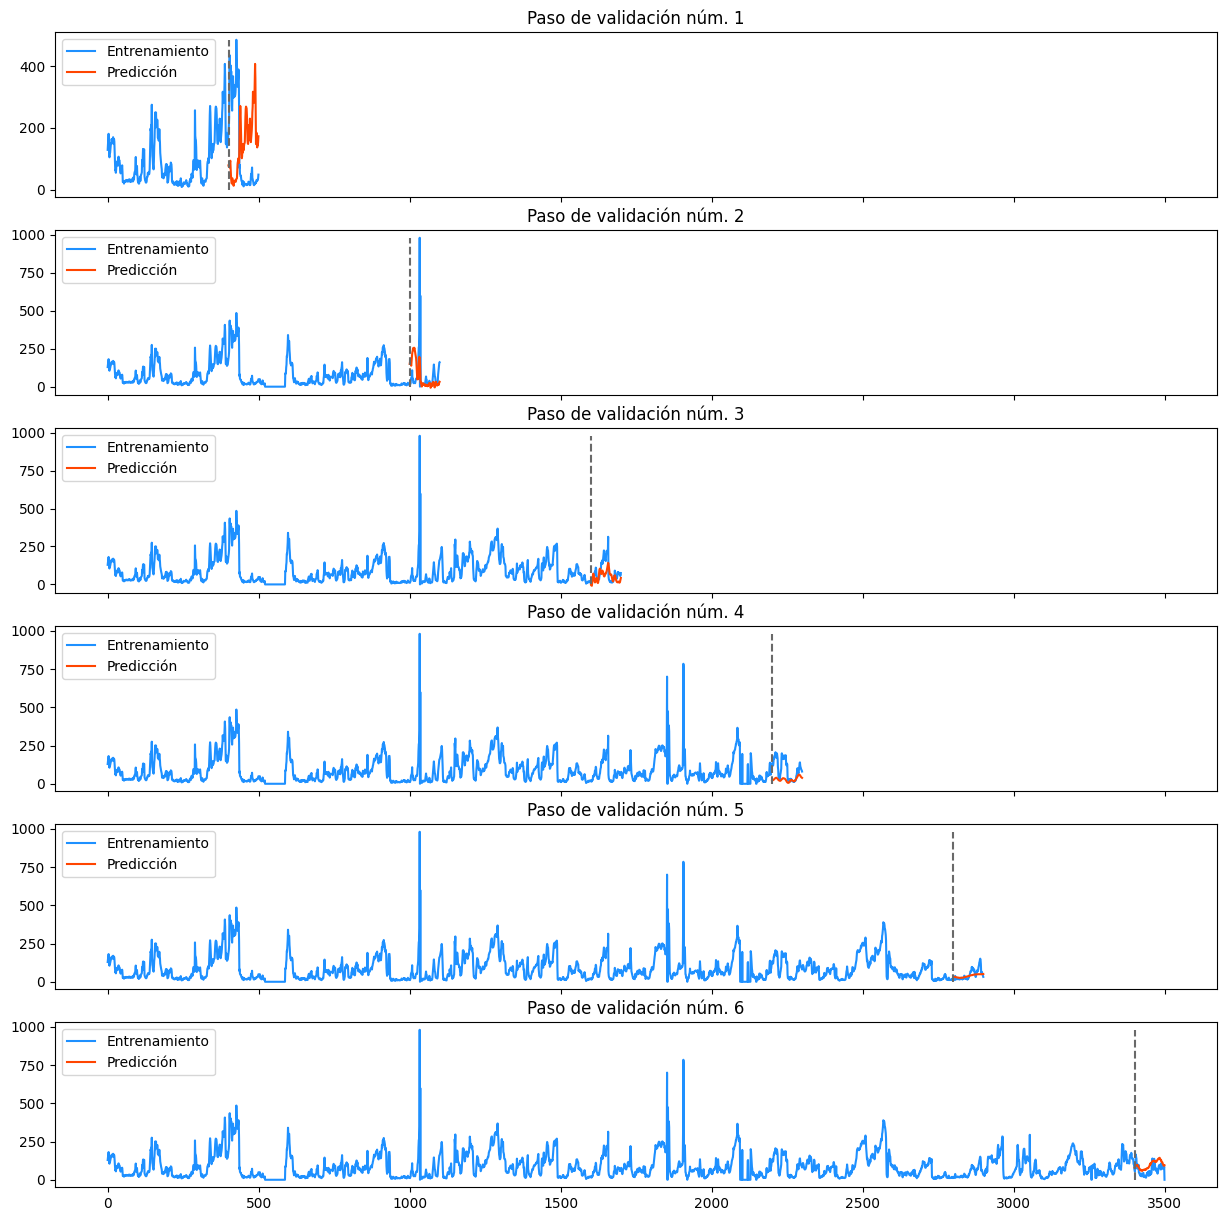

In [242]:
index = 0
fig, axs = plt.subplots(n_chunks, 1, figsize = (15, 15), sharex = True)
for i, ax in zip(range(backcast_size, dataset.shape[0], backcast_size+n_steps_out), axs.ravel()):
    chunk_dataset = dataset.iloc[0:i]
    train = chunk_dataset['pollution'].iloc[0:i-n_steps_out]
    test  = chunk_dataset['pollution'].iloc[i-n_steps_out:i]
    ax.plot( chunk_dataset['pollution'], label = "Entrenamiento", color='dodgerblue')
    ax.plot([None for i in range(train.shape[0])] + [x for x in y_pred_list[index]], label = "Predicción", color='orangered')
    ax.legend(loc = "upper left")
    ax.vlines(x = i-n_steps_out, colors='dimgray', ymin = 0, ymax = max(chunk_dataset['pollution']), linestyles='dashed')
    ax.set_title("Paso de validación núm. " + str(index + 1))
    index = index + 1

Visualmente podemos afirmar que, el pronóstico mejora a medida que aumenta el numero de pasos de validación.

### Análisis del Error Cuadrático Medio (MSE) 

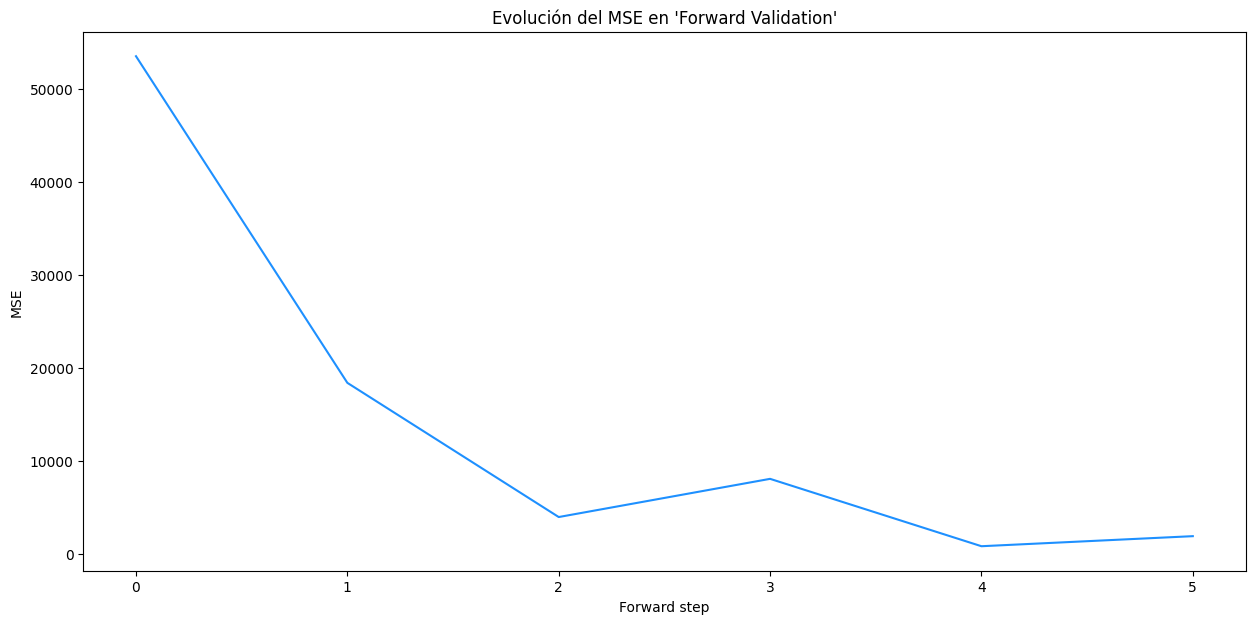

In [243]:
fig, axs = plt.subplots(1, 1, figsize = (15, 7), sharex = True)
plt.plot(mse_list, color='dodgerblue')
plt.title("Evolución del MSE en 'Forward Validation'")
plt.xlabel("Forward step")
plt.ylabel("MSE")
plt.show()

In [257]:
df_MSE = pd.DataFrame({'steps': range(1, len(mse_list) + 1), 'MSE': mse_list})
df_MSE

,steps,MSE
0,1,53534.262298
1,2,18424.836831
2,3,4001.181911
3,4,8105.940618
4,5,863.637398
5,6,1944.850184


Parece razonable, el MSE está disminuyendo a medida que aumentan los pasos de validación y el modelo tiene más datos en el entrenamiento. 

## 6 - Conclusión

Pese a que el MSE se ve reducido con el número de pasos de validación, si los aumentamos más allá del cuarto paso, el modelo puede comportarse de manera extraña debido a una ventana de datos de aprendizaje demasiado extensa.

**¿Posible solución?**

- Una solución podría ser delimitar el número máximo de datos en la ventana de datos historicos para entrenamiento, quedándonos siempre con los últimos n datos anteriores a la predicción. De esta forma el número de datos de entrenamiento no aumenta significativamente, siendo mas eficiente computacionalmente, y reduciendo la varianza de los datos al tomar siempre datos más cercanos al mpmento de predicción




